The purpose of this notebook is to build the BigQuery catalog of NWM quantile data.

In [1]:
import os
import pandas
from pathlib import Path

# utilities libraries
import catalog


In [2]:
outdir = Path('workflow_outputs')
os.makedirs(outdir, exist_ok=True)

In [3]:
# INPUTS 
# read computed statistics.
quantiles = pandas.read_parquet('all_quantiles_good.parquet')

In [4]:
json = catalog.pandas_to_jsonl(quantiles)
with open(outdir/'quantiles.jsonl', 'w') as f:
    f.write(json)

In [6]:
%%time

# upload to gcp
catalog.upload_to_gcs(outdir/'quantiles.jsonl', "com_res_fim_output", "quantiles_catalog_index.jsonl")

Uploaded to gs://com_res_fim_output/quantiles_catalog_index.jsonl


In [10]:
%%time

catalog.load_json_to_bigquery("gs://com_res_fim_output/quantiles_catalog_index.jsonl",
                              "com-res.flood_data.quantiles_catalog")

Loaded 1021140 rows to com-res.flood_data.quantiles_catalog
CPU times: user 36.9 ms, sys: 25.5 ms, total: 62.4 ms
Wall time: 52.9 s


## Test By Querying the BigQuery Catalog

In [13]:
from google.cloud import bigquery

In [37]:
client = bigquery.Client(project="com-res")

query = """
SELECT *
FROM `com-res.flood_data.quantiles_catalog`
WHERE feature_id = @feature_id
ORDER BY doy ASC
"""

In [38]:
reachid = 3627071

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("feature_id", "INT64", reachid),
    ]
)

query_job = client.query(query, job_config=job_config)


In [47]:
dat = []
for row in query_job.result():
    dat.append(dict(q100       = row['q90'],
                    q90        = row['q90'],
                    q75        = row['q75'],
                    q25        = row['q25'],
                    q10        = row['q10'],
                    q05        = row['q5'],
                    q0         = row['q0'],
                    doy        = row['doy'],
                    feature_id = row['feature_id']
                   )
              )
                    
df = pandas.DataFrame(dat)
    

<Axes: xlabel='doy'>

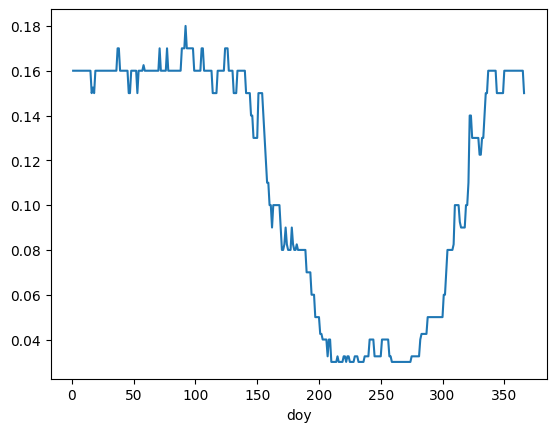

In [49]:
df.set_index('doy', inplace=True)
df.q75.plot()